<a href="https://colab.research.google.com/github/ashikshafi08/Learning-Fastai/blob/main/Chapters%20Notebooks/Training_a_State_of_the_Art_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Thu Apr  8 08:43:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Installing fastai 
!pip install --upgrade fastai

     |████████████████████████████████| 194kB 8.1MB/s 
     |████████████████████████████████| 12.8MB 225kB/s 
     |████████████████████████████████| 61kB 9.3MB/s 
     |████████████████████████████████| 776.8MB 24kB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [4]:
# Importing the needed packages 
import fastai
print(fastai.__version__)
from fastai.vision.all import * 
from fastai import *

2.3.0


This chapter introduces more advanced techniques for training an Image Classification model and getting state-of-the-art results.

We will be looking at things like: 
- **Normalization** 
- **Mixup**:  a powerful data augmentation technique.
- **test time augmentation**

To do this all this, we're going to to train a model from scratch (not use transfer learning) by using a subset of ImageNet called Imagenette. 

It contains a subset of 10 very different categories from the original ImageNet dataset. 

This is going to be much harder to train because, in here we will use **full size, full-color images, which are photos of dfferent sizes, in different orientations and in different lightning**. 

By this chapter we'll learn how to get most out of our dataset, especially when you're training from scratch, or using transfer learning to train a model on a very different kind of dataset than the pretrained model used. 

### Imagenette 

When fastai started out people used three main datasets from building and testing computer vision models.
- ImageNet
- MNIST
- CIFAR 

The problem was smaller the datasets didn't generalize effectively to the large ImageNet dataset. That's how Imagenetter was created, to get rid of this issue, where people could test their algorithms quickly and cheaply, but that would also provide insights likely to work on the full ImageNet dataset.

Imagenette:
- has 10 classes from the **full ImageNet** that looked very different from one another. The tweaks worked on Imagenette really worked well on ImageNet too. 

> The dataset you are given isn't necessarily the dataset you want. And if it's taking too long to experiment, 
- See how can you cut down your dataset 
- Simplify your model 
to improve the experimentation speed. More the experimentation, the better the results.

In [7]:
# Getting the Imagenette dataset 
path = untar_data(URLs.IMAGENETTE)

In [8]:
# Looking what's in the folder 
path.ls()

(#3) [Path('/root/.fastai/data/imagenette2/train'),Path('/root/.fastai/data/imagenette2/noisy_imagenette.csv'),Path('/root/.fastai/data/imagenette2/val')]

In [10]:
# How many classes are there? 
import os
os.listdir(path/'train')

['n03028079',
 'n03417042',
 'n03425413',
 'n02102040',
 'n03394916',
 'n02979186',
 'n01440764',
 'n03445777',
 'n03888257',
 'n03000684']

In [11]:
# Let's build a DataBlock right away 
dblock = DataBlock(blocks = (ImageBlock() , CategoryBlock()),
                   get_items = get_image_files , 
                   get_y = parent_label , 
                   item_tfms = Resize(460) , 
                   batch_tfms = aug_transforms(size = 224 , min_scale= 0.75))

# Here it goes into our dataloaders 
dls = dblock.dataloaders(path , bs = 64)

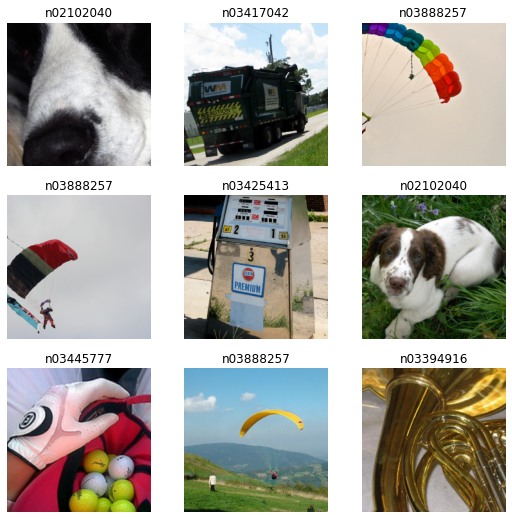

In [14]:
# Visualizing how our data looks? 
dls.show_batch()

In [13]:
# Training a baseline model 
model = xresnet50()
learn = Learner(dls , model , loss_func= CrossEntropyLossFlat() , metrics = accuracy)

# Fitting for 5 epochs 
learn.fit_one_cycle(5 , 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.646014,1.687550,0.476475,02:40
1,1.284401,1.977375,0.399552,02:40
2,0.950289,0.942525,0.689694,02:39
3,0.740560,0.719202,0.781180,02:38
4,0.605331,0.570172,0.824122,02:36


The above is just a baseline model, we are not using a pre-trained model here. 

When working with the models that are being trained from scratch or fine tuned to a very different dataset from the one used for pretraining, some additional techniques are really important. 

## Normalization

Our input data needs to be normalized while we train our model, that is, has a **mean of 0 and standard deviation of 1.**

But most images and computer vision libraries use values ranging between, 
- 0 - 255 
- 0 - 1 for pixels

In either case your data is not goig to have a mean of 0 and standard deviation of 1. 

Let's grab a batch of our data and look at those values, by averaging over all axes except for the channel axis. 

In [15]:
x , y = dls.one_batch()

In [24]:
x.shape , y.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

In [25]:
# Averaging over all axes except the channel
x.mean(dim = [0, 2, 3]) , x.std(dim = [0 , 2, 3])

(TensorImage([0.4668, 0.4732, 0.4607], device='cuda:0'),
 TensorImage([0.2841, 0.2828, 0.3095], device='cuda:0'))

Looking at this we know that the mean and standard deviation are not very close to the desired values. 

We can normalize the values in fastai by just adding the `Normalize` transform. This acts on **whole mini-batch at once**, so you can add it to the `batch_tfms` section of your datablock.

For `Normalize` we gotta pass the mean and std we want to use, but fastai comes with the standard ImageNet mean and standard deviation already defined. 

`imagenet_stats` -->  stats of ImageNet 




In [30]:
# Putting everything into a function (Added Normalization)
def get_dls(bs , size):
  dblock = DataBlock(
      blocks = (ImageBlock() , CategoryBlock()), 
      get_items = get_image_files, 
      get_y = parent_label, 
      item_tfms = Resize(460) , 
      batch_tfms = [*aug_transforms(size= size , min_scale=0.75) , 
                    Normalize.from_stats(*imagenet_stats)]
  )

  return dblock.dataloaders(path , bs = bs)

In [31]:
# Using the function
dls = get_dls(64 , 224)

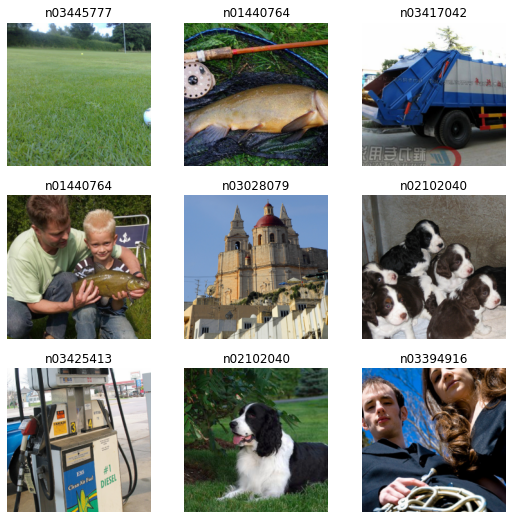

In [32]:
# Visualizing 
dls.show_batch()

Now let's take one mini-batch and chech the mean and standard deviation to see if they're normalized. 

In [33]:
x , y = dls.one_batch() 
x.mean(dim = [0 , 2 ,3]) , x.std(dim = [0 , 2, 3])

(TensorImage([0.0528, 0.0869, 0.1597], device='cuda:0'),
 TensorImage([1.1686, 1.1700, 1.2701], device='cuda:0'))

Look at that!! Before the values wasn't in the range of our expectation. Now looking into the mean and std, it's sure our values are normalized.